## Imports

In [3]:
from base_Imports_and_Functions import *

df_mf = pd.read_pickle(savecsv_path+'mf_19.csv')
df_net = pd.read_pickle(savecsv_path+'net_19.csv')

df_mf_son = df_mf[(df_mf['lat'] >=extent_son[2]) & (df_mf['lat'] <= extent_son[3]) &
  (df_mf['lon'] >= extent_son[0]) & (df_mf['lon'] <= extent_son[1])]

df_net_son = df_net[(df_net['lat'] >=extent_son[2]) & (df_net['lat'] <= extent_son[3]) &
  (df_net['lon'] >= extent_son[0]) & (df_net['lon'] <= extent_son[1])]

Elevation_father = xr.open_dataset(savenet_path+'Elevation_father.nc') 

Elevation_father_ = Elevation_father.where(
    (Elevation_father['lon'] > extent_son[0]) & (Elevation_father['lon'] < extent_son[1]) & 
    (Elevation_father['lat'] > extent_son[2]) & (Elevation_father['lat'] < extent_son[3]),
    drop = True)

## Producting netcdf from simu

In [4]:
@njit()
def arange_netcdf_uvrv(simu_array,it,n,m):
    
    Rv = np.ravel(simu_array[7,it,0])
    U = np.ravel(simu_array[0,it,0])
    V = np.ravel(simu_array[1,it,0])
    Rh = np.ravel(simu_array[6,it,0])
    T_pot = np.ravel(simu_array[5,it,0])
    P = np.ravel(simu_array[4,it,0])
    iteration = np.ravel(np.ones((n,m))*it)

    return Rv,U,V,Rh,T_pot,P,iteration

def to_netcdf_simu_rvuv(coords_netcdf, simu_array, jour, heure_debut, save_name): 

    vars,its,levels,n,m = np.shape(simu_array)

    latitudes = np.ravel(coords_netcdf['latitude'].values[1:-1,1:-1])
    longitudes = np.ravel(coords_netcdf['longitude'].values[1:-1,1:-1])
    
    latitudes_i = latitudes.copy()
    longitudes_i = longitudes.copy()
    
    var = 7
    Rv_i = np.ravel(simu_array[var,0,0])
    var = 0
    U_i= np.ravel(simu_array[var,0,0])
    var = 1
    V_i = np.ravel(simu_array[var,0,0])
    var = 6
    Rh_i = np.ravel(simu_array[var,0,0])
    var = 5
    T_pot_i = np.ravel(simu_array[var,0,0])
    var = 4
    P_i = np.ravel(simu_array[var,0,0])
    
    heure_i = np.ravel(np.ones((n,m))*heure_debut)

    for it in range(heure_debut+1,heure_debut+its): 

        Rv,U,V,Rh,T_pot,P,iteration = arange_netcdf_uvrv(simu_array,it,n,m)

        Rv_i = np.concatenate((Rv_i, Rv), axis=None)
        U_i = np.concatenate((U_i, U), axis=None)
        V_i = np.concatenate((V_i, V), axis=None)
        Rh_i = np.concatenate((Rh_i, Rh), axis=None)
        T_pot_i = np.concatenate((T_pot_i, T_pot), axis=None)
        P_i = np.concatenate((P_i, P), axis=None)
        latitudes_i = np.concatenate((latitudes_i, latitudes), axis=None)
        longitudes_i = np.concatenate((longitudes_i, longitudes), axis=None)
        heure_i = np.concatenate((heure_i, np.ravel(np.ones((n,m))*it)), axis=None)
        
        print(it, ' ok')
        
    num_events = len(longitudes_i)
    num_data_points = 9
    Simu_netcdf = xr.Dataset(
        {
            'Rv': (['event'], Rv_i.astype(np.float32)),
            'U': (['event'], U_i.astype(np.float32)),
            'V': (['event'], V_i.astype(np.float32)),
            'Rh': (['event'], Rh_i.astype(np.float32)),
            'T_pot': (['event'], T_pot_i.astype(np.float32)),
            'P': (['event'], P_i.astype(np.float32)),
            'lat': (['event'], latitudes_i.astype(np.float32)),
            'lon': (['event'], longitudes_i.astype(np.float32)),
            'heure': (['event'], heure_i.astype(int))
        },
        coords={
            'event': np.arange(num_events)
        },
    )
    
    Simu_netcdf.to_netcdf(savenet_path+save_name + '.nc')

## Comparison with Meteorological stations

In [5]:
def Comp_rvuv(day,dlat,dlon,df_net_son,df_mf_son,Simu_0_23_son,Elevation_father_,save_name):

    lon_comp_i = np.zeros((1,1))[0]
    lat_comp_i = np.zeros((1,1))[0]
    heure_i = np.zeros((1,1))[0]
    type_i = np.zeros((1,1))[0] #0 si Net, 1 si MF
    station_i = np.zeros((6,1))
    simu_i = np.zeros((6,1))
    bias_i = np.zeros((6,1))
    T_sta_paspot_i = np.zeros((1,1))[0]
    
    hours = np.arange(0,24,1)
    for it in tqdm(range(len(hours))):

        df_net_son_it = df_net_son[(df_net_son['rawtime'] == it*60*60)]
        df_mf_son_it = df_mf_son[(df_mf_son['rawtime'] == it*60*60)]

        lon_net = df_net_son_it['lon'].values
        lon_mf = df_mf_son_it['lon'].values
        lat_net = df_net_son_it['lat'].values
        lat_mf = df_mf_son_it['lat'].values

        press_mf = filled_press_values(df_mf_son_it['pression (Pa)'].values,df_mf_son_it['altitude_baromètre (m)'].values,df_mf_son_it['altitude_station (m)'].values)
        
        station_mf = np.array([df_mf_son_it['altitude_baromètre (m)'].values,
                               press_mf,
                               list(compute_potential_T(press_mf,df_mf_son_it['T-1.5'].values)-273.15),
                               compute_rv_from_rh(press_mf,df_mf_son_it['T-1.5'].values,df_mf_son_it['hu'].values)*1000,
                               df_mf_son_it['u_moy'].values,
                               df_mf_son_it['dir_vent_moy'].values])
        
        station_net = np.array([df_net_son_it['alt'].values,
                                #list(compute_press(df_net_son_it['alt'].values)),
                                df_net_son_it['psta'].values*100,
                                list(compute_potential_T(df_net_son_it['psta'].values*100,df_net_son_it['Temp'].values + 273.15)-273.15),
                                compute_rv_from_rh(df_net_son_it['psta'].values*100,df_net_son_it['Temp'].values + 273.15,df_net_son_it['hu'].values)*1000,
                               [np.nan for i in range(len(df_net_son_it['alt'].values))],
                               [np.nan for i in range(len(df_net_son_it['alt'].values))]])

        Simu_it = Simu_0_23_son.where(
            (Simu_0_23_son['heure'] == it),
            drop = True)

        if (len(Simu_it['heure'].values) != 0) and (len(lon_net) != 0) and (len(lon_mf) != 0) :

            lon_simu = Simu_it['lon'].values
            lat_simu = Simu_it['lat'].values

            Simu_array = np.array([Elevation_father_['ZS'],
                                   Simu_it['P'],
                                   Simu_it['T_pot'],
                                   Simu_it['Rv'],
                                   np.sqrt(Simu_it['U']**2 + Simu_it['V']**2),
                                   np.arctan(Simu_it['V']/Simu_it['U'])])

            lon_inf_net = lon_net-dlon
            lon_sup_net = lon_net+dlon
            lat_inf_net = lat_net-dlat
            lat_sup_net = lat_net+dlat

            lon_inf_mf = lon_mf-dlon
            lon_sup_mf = lon_mf+dlon
            lat_inf_mf = lat_mf-dlat
            lat_sup_mf = lat_mf+dlat
            
            res_net,res_trace_net,res_simu_net = compare_ground_rvuv(lon_inf_net,lon_sup_net,lat_inf_net,lat_sup_net,station_net,lon_simu,lat_simu,Simu_array)
            
            lon_comp_i = np.concatenate((lon_comp_i,lon_net), axis = 0)
            lat_comp_i = np.concatenate((lat_comp_i,lat_net), axis = 0)
            bias_i = np.concatenate((bias_i,res_net), axis = 1)
            heure_i = np.concatenate((heure_i,np.ones((1,len(lon_net)))[0]*it), axis = 0)
            station_i = np.concatenate((station_i,res_trace_net), axis = 1)
            simu_i = np.concatenate((simu_i,res_simu_net), axis = 1)
            type_i = np.concatenate((type_i,np.zeros((1,len(lon_net)))[0]), axis = 0)
            T_sta_paspot_i = np.concatenate((T_sta_paspot_i,df_net_son_it['Temp'].values), axis = 0)
    
            res_mf,res_trace_mf,res_simu_mf = compare_ground_rvuv(lon_inf_mf,lon_sup_mf,lat_inf_mf,lat_sup_mf,station_mf,lon_simu,lat_simu,Simu_array)

            lon_comp_i = np.concatenate((lon_comp_i,lon_mf), axis = 0)
            lat_comp_i = np.concatenate((lat_comp_i,lat_mf), axis = 0)
            bias_i = np.concatenate((bias_i,res_mf), axis = 1)
            heure_i = np.concatenate((heure_i,np.ones((1,len(lon_mf)))[0]*it), axis = 0)
            station_i = np.concatenate((station_i,res_trace_mf), axis = 1)
            simu_i = np.concatenate((simu_i,res_simu_mf), axis = 1)
            type_i = np.concatenate((type_i,np.ones((1,len(lon_mf)))[0]), axis = 0)
            T_sta_paspot_i = np.concatenate((T_sta_paspot_i,df_mf_son_it['T-1.5'].values-273.15), axis = 0)
    
    num_events = len(heure_i)-1
    num_data_points = 23
    Comp_simu_rvuv = xr.Dataset(
        {
        'lon_comp': (['event'], lon_comp_i[1:].astype(np.float32)),
        'lat_comp': (['event'], lat_comp_i[1:].astype(np.float32)),
            
        'Z_sta': (['event'], station_i[0,:][1:].astype(np.float32)),
        'Z_simu': (['event'], simu_i[0,:][1:].astype(np.float32)),
        'Z_bias': (['event'], bias_i[0,:][1:].astype(np.float32)),

        'P_sta': (['event'], station_i[1,:][1:].astype(np.float32)),
        'P_simu': (['event'], simu_i[1,:][1:].astype(np.float32)),
        'P_biai': (['event'], bias_i[1,:][1:].astype(np.float32)),
            
        'T_sta_paspot': (['event'], T_sta_paspot_i[1:].astype(np.float32)),
        'T_sta': (['event'], station_i[2,:][1:].astype(np.float32)),
        'T_simu': (['event'], simu_i[2,:][1:].astype(np.float32)),
        'T_biai': (['event'], bias_i[2,:][1:].astype(np.float32)),

        'Rv_sta': (['event'], station_i[3,:][1:].astype(np.float32)),
        'Rv_simu': (['event'], simu_i[3,:][1:].astype(np.float32)),
        'Rv_biai': (['event'], bias_i[3,:][1:].astype(np.float32)),

        'U_moy_sta': (['event'], station_i[4,:][1:].astype(np.float32)),
        'U_moy_simu': (['event'], simu_i[4,:][1:].astype(np.float32)),
        'U_moy_biai': (['event'], bias_i[4,:][1:].astype(np.float32)),

        'Dir_moy_sta': (['event'], station_i[5,:][1:].astype(np.float32)),
        'Dir_moy_simu': (['event'], simu_i[5,:][1:].astype(np.float32)),
        'Dir_moy_biai': (['event'], bias_i[5,:][1:].astype(np.float32)),
        
        'heure': (['event'], heure_i[1:].astype(int)),
        'type': (['event'], type_i[1:].astype(int))
    },
    coords={
        'event': np.arange(num_events)
    },
    )
    
    Comp_simu_rvuv.to_netcdf(savenet_path+save_name+'.nc')   

In [ ]:
type = ['AROME','father','son']
for i in range(2) :
    for j in type:
        Simu_0_23 = xr.open_dataset(savenet_path+'j'+'_'+str(19+i)+'_RvUV' + '.nc')
        Comp_rvuv(i+19,0.01,0.01,df_net_son,df_mf_son,Simu_0_23,Elevation_father_,'comp_'+j+'_'+str(19+i)+'_RvUV.nc')

## Plotting

In [6]:
### AROME
Comp_simu_rvuv_19_AROME = xr.open_dataset(savenet_path+'comp_AROME_19_RvUV.nc') 
Comp_simu_rvuv_20_AROME = xr.open_dataset(savenet_path+'comp_AROME_20_RvUV.nc') 

Simu_AROME_19 = xr.open_dataset(savenet_path+'AROME_19_RvUV.nc')

reduced_AROME_19_14 = Simu_AROME_19.where(
    (Simu_AROME_19['heure'] == 14),
    drop = True)
reduced_comp_19_AROME_14 = Comp_simu_rvuv_19_AROME.where(
    (Comp_simu_rvuv_19_AROME['heure'] == 14),
    drop = True)
reduced_comp_net_19_AROME_14 = reduced_comp_19_AROME_14.where(
    (reduced_comp_19_AROME_14['type'] == 0),
        drop = True)
reduced_comp_mf_19_AROME_14 = reduced_comp_19_AROME_14.where(
    (reduced_comp_19_AROME_14['type'] == 1),
        drop = True)

reduced_comp_19_AROME_4 = Comp_simu_rvuv_19_AROME.where(
    (Comp_simu_rvuv_19_AROME['heure'] == 4),
    drop = True)
reduced_comp_net_19_AROME_4 = reduced_comp_19_AROME_4.where(
    (reduced_comp_19_AROME_4['type'] == 0),
        drop = True)
reduced_comp_mf_19_AROME_4 = reduced_comp_19_AROME_4.where(
    (reduced_comp_19_AROME_4['type'] == 1),
        drop = True)

### Father
Comp_simu_rvuv_19_father = xr.open_dataset(savenet_path+'comp_father_19_RvUV.nc') 
Comp_simu_rvuv_20_father = xr.open_dataset(savenet_path+'comp_father_20_RvUV.nc') 

Simu_father_19 = xr.open_dataset(savenet_path+'father_19_RvUV.nc')

reduced_father_19_14 = Simu_father_19.where(
    (Simu_father_19['heure'] == 14),
    drop = True)
reduced_comp_19_father_14 = Comp_simu_rvuv_19_father.where(
    (Comp_simu_rvuv_19_father['heure'] == 14),
    drop = True)
reduced_comp_net_19_father_14 = reduced_comp_19_father_14.where(
    (reduced_comp_19_father_14['type'] == 0),
        drop = True)
reduced_comp_mf_19_father_14 = reduced_comp_19_father_14.where(
    (reduced_comp_19_father_14['type'] == 1),
        drop = True)

reduced_comp_19_father_4 = Comp_simu_rvuv_19_father.where(
    (Comp_simu_rvuv_19_father['heure'] == 4),
    drop = True)
reduced_comp_net_19_father_4 = reduced_comp_19_father_4.where(
    (reduced_comp_19_father_4['type'] == 0),
        drop = True)
reduced_comp_mf_19_father_4 = reduced_comp_19_father_4.where(
    (reduced_comp_19_father_4['type'] == 1),
        drop = True)

### Son 
Comp_simu_rvuv_19_son = xr.open_dataset(savenet_path+'comp_son_19_RvUV.nc') 
Comp_simu_rvuv_20_son = xr.open_dataset(savenet_path+'comp_son_20_RvUV.nc') 

Simu_son_19 = xr.open_dataset(savenet_path+'son_19_RvUV.nc')

reduced_son_19_14 = Simu_son_19.where(
    (Simu_son_19['heure'] == 14),
    drop = True)
reduced_comp_19_son_14 = Comp_simu_rvuv_19_son.where(
    (Comp_simu_rvuv_19_son['heure'] == 14),
    drop = True)
reduced_comp_net_19_son_14 = reduced_comp_19_son_14.where(
    (reduced_comp_19_son_14['type'] == 0),
        drop = True)
reduced_comp_mf_19_son_14 = reduced_comp_19_son_14.where(
    (reduced_comp_19_son_14['type'] == 1),
        drop = True)

reduced_comp_19_son_4 = Comp_simu_rvuv_19_son.where(
    (Comp_simu_rvuv_19_son['heure'] == 4),
    drop = True)
reduced_comp_net_19_son_4 = reduced_comp_19_son_4.where(
    (reduced_comp_19_son_4['type'] == 0),
        drop = True)
reduced_comp_mf_19_son_4 = reduced_comp_19_son_4.where(
    (reduced_comp_19_son_4['type'] == 1),
        drop = True)

In [8]:
def plotting_time_series_quantils_rvuv(netcdf,vars): 
    medians = np.zeros((8,24))
    lows = np.zeros((8,24))
    highs = np.zeros((8,24))
    for i in range(4) :
        medians[2*i,:] = compute_diurn_cycle(var[2*i], var[2*i+1],50,netcdf)[0]
        medians[2*i+1,:] = compute_diurn_cycle(var[2*i], var[2*i+1],50,netcdf)[1]
    
        highs[2*i,:] = compute_diurn_cycle(var[2*i], var[2*i+1],75,netcdf)[0]
        highs[2*i+1,:] = compute_diurn_cycle(var[2*i], var[2*i+1],75,netcdf)[1]
    
        lows[2*i,:] = compute_diurn_cycle(var[2*i], var[2*i+1],25,netcdf)[0]
        lows[2*i+1,:] = compute_diurn_cycle(var[2*i], var[2*i+1],25,netcdf)[1]
    return lows,medians,highs

def plotting(reduced_father_19,reduced_comp_net_19,reduced_comp_mf_19,reduced_comp_net_19_6,reduced_comp_mf_19_6,Comp_simu_rvuv_19,day,type,save_name,color_plot):
    
    fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize=(15,12),layout="constrained")
    
    var = ['T_simu','T_sta','U_moy_simu','U_moy_sta','Rv_simu','Rv_sta','P_simu','P_sta']
    var_simu = ['T_pot','U', 'Rv','P']
    cmaps = ['RdYlBu_r','inferno','YlGnBu_r','viridis']
    scatter_labels = ['$\\theta$ simulation (°C)','$\\theta$ station (°C)','Wind norm simu ($m.s^{-1}$)','Wind norm station ($m.s^{-1}$)',
                      'Rv simulation (g/kg)','Rv station (g/kg)','Pression simulation (Bar)','Pression station (Bar)']
    diurn_labels = ['$\\theta$ (°C)', 'Wind norm ($m.s^{-1}$)','Rv (g/kg)','Pression (Bar)']
    
    min_l = [35,0,5,0.6]
    max_l = [45,7,20,1.1]
    pas = [1,1,3,0.1]
    extends = ['both','max','both','both']
    clabels = ['$\\theta$ (°C)','||U|| ($m.s^{-1}$)','Rv (g/kg)','Pression (Bar)']
    P0 = 100000
    laterals = [4,2,3,0.05]
    ymin = [20,0,5,0.85]
    ymax = [45,6,14,1.005]

    filled_marker_style = dict(markeredgecolor='k')
    
    for i in range(3):
        for j in range(4) :
        
            ax = axs[i,j]
            ax.tick_params('x', labelsize=size)
            ax.tick_params('y', labelsize=size)
            ax.text(0, 1.1, string.ascii_lowercase[i*4+j], transform=ax.transAxes, 
                size=20, weight='bold')
    
            if j == 0 :
                if var_simu[i] == 'U' :
                    c = np.sqrt(reduced_father_19['U'].values**2 + reduced_father_19['V'].values**2)
                    cax = ax.scatter(reduced_father_19['lon'],reduced_father_19['lat'], s = 1,c = c,cmap = cmaps[i],vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_net_19['lon_comp'],reduced_comp_net_19['lat_comp'],c = reduced_comp_net_19[var[2*i+1]],cmap = cmaps[i],marker = 'X', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_mf_19['lon_comp'],reduced_comp_mf_19['lat_comp'],c = reduced_comp_mf_19[var[2*i+1]],cmap = cmaps[i],marker = 'P', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
    
                elif var_simu[i] == 'T_pot' :
                    c = reduced_father_19[var_simu[i]]-273.15
                    cax = ax.scatter(reduced_father_19['lon'],reduced_father_19['lat'], s = 1,c = c,cmap = cmaps[i],vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_net_19['lon_comp'],reduced_comp_net_19['lat_comp'],c = reduced_comp_net_19[var[2*i+1]],cmap = cmaps[i],marker = 'X', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_mf_19['lon_comp'],reduced_comp_mf_19['lat_comp'],c = reduced_comp_mf_19[var[2*i+1]],cmap = cmaps[i],marker = 'P', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                    
                elif var_simu[i] == 'P' :
                    c = reduced_father_19[var_simu[i]]/P0
                    cax = ax.scatter(reduced_father_19['lon'],reduced_father_19['lat'], s = 1,c = c,cmap = cmaps[i],vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_net_19['lon_comp'],reduced_comp_net_19['lat_comp'],c = reduced_comp_net_19[var[2*i+1]]/P0,cmap = cmaps[i],marker = 'X', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_mf_19['lon_comp'],reduced_comp_mf_19['lat_comp'],c = reduced_comp_mf_19[var[2*i+1]]/P0,cmap = cmaps[i],marker = 'P', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                else :
                    c = reduced_father_19[var_simu[i]]
                    cax = ax.scatter(reduced_father_19['lon'],reduced_father_19['lat'], s = 1,c = c,cmap = cmaps[i],vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_net_19['lon_comp'],reduced_comp_net_19['lat_comp'],c = reduced_comp_net_19[var[2*i+1]],cmap = cmaps[i],marker = 'X', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                    ax.scatter(reduced_comp_mf_19['lon_comp'],reduced_comp_mf_19['lat_comp'],c = reduced_comp_mf_19[var[2*i+1]],cmap = cmaps[i],marker = 'P', edgecolors='k',vmin = min_l[i], vmax = max_l[i])
                
                ax.set_xlabel('°E',fontsize = size)
                ax.set_ylabel('°N',fontsize = size)
            
                ticks = np.arange(min_l[i],max_l[i]+pas[i],pas[i])

                if var_simu[i] == 'P' : 
                    ticks = [0.6+0.1*i for i in range(6)]
                
                cbar = fig.colorbar(cax,
                            ax = ax,
                            ticks=ticks,
                            format=mticker.FixedFormatter(ticks),
                            location = 'left',
                            extend=extends[i],
                            orientation='vertical',
                            fraction = 0.028,
                            aspect = 55,
                            boundaries = ticks
                            )
            
                cbar.ax.tick_params(labelsize=size) 
                cbar.ax.set_title(label = clabels[i], fontsize=size)
                ax.set_xlim((5.499792,7.032229))
                ax.set_ylim((44.104446,45.18888))
    
                ax.scatter([-10],[-10], marker = '+', color = 'k', label = 'RADOME')
                ax.scatter([-10],[-10], marker = 'x', color = 'k', label = 'Net')

                ax.set_title(type +' 14h '+str(day)+'/08',fontsize = size)
    
                ax.legend()
                
            if j == 2 :
    
                if var_simu[i] == 'T_pot' :
                    cax = ax.scatter(reduced_comp_net_19[var[2*i+1]],reduced_comp_net_19[var[2*i]]-273.15,c = reduced_comp_net_19['Z_sta'],cmap = 'terrain',marker = 'o',vmin = 0, vmax = 4000)
                    ax.scatter(reduced_comp_mf_19[var[2*i+1]],reduced_comp_mf_19[var[2*i]]-273.15,c = reduced_comp_mf_19['Z_sta'],cmap = 'terrain',marker = 'o', edgecolor = 'k',vmin = 0, vmax = 4000)
                    ax.plot(np.linspace(20,50,10000),np.linspace(20,50,10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(20,50,10000)+laterals[i],np.linspace(20,50,10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(20,50,10000),np.linspace(20,50,10000)+laterals[i],color = 'k', linestyle = 'dashed')
    
                elif var_simu[i] == 'P' :
                    cax = ax.scatter(reduced_comp_net_19[var[2*i+1]]/P0,reduced_comp_net_19[var[2*i]]/P0,c = reduced_comp_net_19['Z_sta'],cmap = 'terrain',marker = 'o',vmin = 0, vmax = 4000)
                    ax.scatter(reduced_comp_mf_19[var[2*i+1]]/P0,reduced_comp_mf_19[var[2*i]]/P0,c = reduced_comp_mf_19['Z_sta'],cmap = 'terrain',marker = 'o',edgecolor = 'k',vmin = 0, vmax = 4000)
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000)+laterals[i],np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000)+laterals[i],color = 'k', linestyle = 'dashed')
    
                else :
                    cax = ax.scatter(reduced_comp_net_19[var[2*i+1]],reduced_comp_net_19[var[2*i]],c = reduced_comp_net_19['Z_sta'],cmap = 'terrain',marker = 'o',vmin = 0, vmax = 4000)
                    ax.scatter(reduced_comp_mf_19[var[2*i+1]],reduced_comp_mf_19[var[2*i]],c = reduced_comp_mf_19['Z_sta'],cmap = 'terrain',marker = 'o',edgecolor = 'k',vmin = 0, vmax = 4000)
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000)+laterals[i],np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000)+laterals[i],color = 'k', linestyle = 'dashed')


                ax.set_xlabel(scatter_labels[2*i+1],fontsize = size)
                ax.set_ylabel(scatter_labels[2*i],fontsize = size)
    
                if i == 2 :
    
                    ticks = np.arange(0,5000,1000)
                    
                    cbar = fig.colorbar(cax,
                                ax = axs[2,1:-1],
                                ticks=ticks,
                                format=mticker.FixedFormatter(ticks),
                                location = 'bottom',
                                extend='max',
                                orientation='horizontal',
                                fraction = 0.028,
                                aspect = 55,
                                boundaries = ticks
                                )
                
                    cbar.ax.tick_params(labelsize=size) 
                    cbar.ax.set_title(label = 'Elevation (m asl)',fontsize = size)
    
                ax.scatter([-10],[-10], marker = 'o', color = 'y', edgecolor ='k', label = 'RADOME')
                ax.scatter([-10],[-10], marker = 'o', color = 'y',  label = 'Net')
                if var_simu[i] == 'T_pot' :
                    ax.set_xlim((20,50))
                    ax.set_ylim((20,50))
                else :
                    ax.set_xlim((min_l[i],max_l[i]))
                    ax.set_ylim((min_l[i],max_l[i]))
                ax.legend()
                ax.set_title('14h '+str(day)+'/08',fontsize = size)

            if j == 1 :
    
                if var_simu[i] == 'T_pot' :
                    cax = ax.scatter(reduced_comp_net_19_6[var[2*i+1]],reduced_comp_net_19_6[var[2*i]]-273.15,c = reduced_comp_net_19_6['Z_sta'],cmap = 'terrain',marker = 'o',vmin = 0, vmax = 4000)
                    ax.scatter(reduced_comp_mf_19_6[var[2*i+1]],reduced_comp_mf_19_6[var[2*i]]-273.15,c = reduced_comp_mf_19_6['Z_sta'],cmap = 'terrain',marker = 'o', edgecolor = 'k',vmin = 0, vmax = 4000)
                    ax.plot(np.linspace(15,50,10000),np.linspace(15,50,10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(15,50,10000)+laterals[i],np.linspace(15,50,10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(15,50,10000),np.linspace(15,50,10000)+laterals[i],color = 'k', linestyle = 'dashed')
    
                elif var_simu[i] == 'P' :
                    cax = ax.scatter(reduced_comp_net_19_6[var[2*i+1]]/P0,reduced_comp_net_19_6[var[2*i]]/P0,c = reduced_comp_net_19_6['Z_sta'],cmap = 'terrain',marker = 'o',vmin = 0, vmax = 4000)
                    ax.scatter(reduced_comp_mf_19_6[var[2*i+1]]/P0,reduced_comp_mf_19_6[var[2*i]]/P0,c = reduced_comp_mf_19_6['Z_sta'],cmap = 'terrain',marker = 'o', edgecolor = 'k',vmin = 0, vmax = 4000)
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000)+laterals[i],np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000)+laterals[i],color = 'k', linestyle = 'dashed')
    
                else :
                    cax = ax.scatter(reduced_comp_net_19_6[var[2*i+1]],reduced_comp_net_19_6[var[2*i]],c = reduced_comp_net_19_6['Z_sta'],cmap = 'terrain',marker = 'o',vmin = 0, vmax = 4000)
                    ax.scatter(reduced_comp_mf_19_6[var[2*i+1]],reduced_comp_mf_19_6[var[2*i]],c = reduced_comp_mf_19_6['Z_sta'],cmap = 'terrain',marker = 'o', edgecolor = 'k',vmin = 0, vmax = 4000)
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000)+laterals[i],np.linspace(min_l[i],max_l[i],10000),color = 'k', linestyle = 'dashed')
                    ax.plot(np.linspace(min_l[i],max_l[i],10000),np.linspace(min_l[i],max_l[i],10000)+laterals[i],color = 'k', linestyle = 'dashed')
                        

                ax.set_xlabel(scatter_labels[2*i+1],fontsize = size)
                ax.set_ylabel(scatter_labels[2*i],fontsize = size)
    
                ax.scatter([-10],[-10], marker = 'o', color = 'y', edgecolor = 'k', label = 'RADOME')
                ax.scatter([-10],[-10], marker = 'o', color = 'y', label = 'Net')
                if var_simu[i] == 'T_pot' :
                    ax.set_xlim((15,50))
                    ax.set_ylim((15,50))
                else :
                    ax.set_xlim((min_l[i],max_l[i]))
                    ax.set_ylim((min_l[i],max_l[i]))
                ax.legend()
                ax.set_title('4h '+str(day)+'/08',fontsize = size)
    
            if j == 3 :
    
                ticks_time = np.array([i for i in range(0,24,4)])
                labels_ticks_time = [str(i)+'h' for i in ticks_time]
                
                ax.grid(visible=True, axis='both', color = '0.80')
                ax.set_xticks(ticks_time, labels_ticks_time,fontsize = size)

                lows,medians,highs = fill_traces(Comp_simu_rvuv_19)
    
                if i == 0 :
                    ax.fill_between(np.arange(0,24,1), lows[2*i,:], highs[2*i,:],color = 'k',alpha = 0.3)
                    ax.fill_between(np.arange(0,24,1), lows[2*i+1,:]-273.15, highs[2*i+1,:]-273.15,color = color_plot,alpha = 0.3)
                    ax.plot(np.arange(0,24,1),medians[2*i,:],'k',label ='Station')
                    ax.plot(np.arange(0,24,1),medians[2*i+1,:]-273.15,color_plot,label = 'simulation')

                elif i == 3 :
                    P0 = 100000
                    ax.fill_between(np.arange(0,24,1), lows[2*i,:]/P0, highs[2*i,:]/P0,color = 'k',alpha = 0.3)
                    ax.fill_between(np.arange(0,24,1), lows[2*i+1,:]/P0, highs[2*i+1,:]/P0,color = color_plot,alpha = 0.3)
                    ax.plot(np.arange(0,24,1),medians[2*i,:]/P0,'k',label ='Station')
                    ax.plot(np.arange(0,24,1),medians[2*i+1,:]/P0,color_plot,label = 'simulation')

                else :
                    ax.fill_between(np.arange(0,24,1), lows[2*i,:], highs[2*i,:],color = 'k',alpha = 0.3)
                    ax.fill_between(np.arange(0,24,1), lows[2*i+1,:], highs[2*i+1,:],color = color_plot,alpha = 0.3)
                    ax.plot(np.arange(0,24,1),medians[2*i,:],'k',label ='Station')
                    ax.plot(np.arange(0,24,1),medians[2*i+1,:],color_plot,label = 'simulation')

                ax.vlines(14, ymin = ymin[i], ymax = ymax[i], linestyle = 'dashed', color  ='r')
                ax.vlines(4, ymin = ymin[i], ymax = ymax[i], linestyle = 'dashed', color  ='r')
                    
                ax.set_ylabel(diurn_labels[i],fontsize = size)
                ax.legend()
                ax.set_title(type + ' ' + str(day) +'/08',fontsize = size)
    
    plt.savefig(savefig_path+save_name+'.png')

C:\Users\barroisl\.conda\envs\barbapapa\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\barroisl\.conda\envs\barbapapa\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


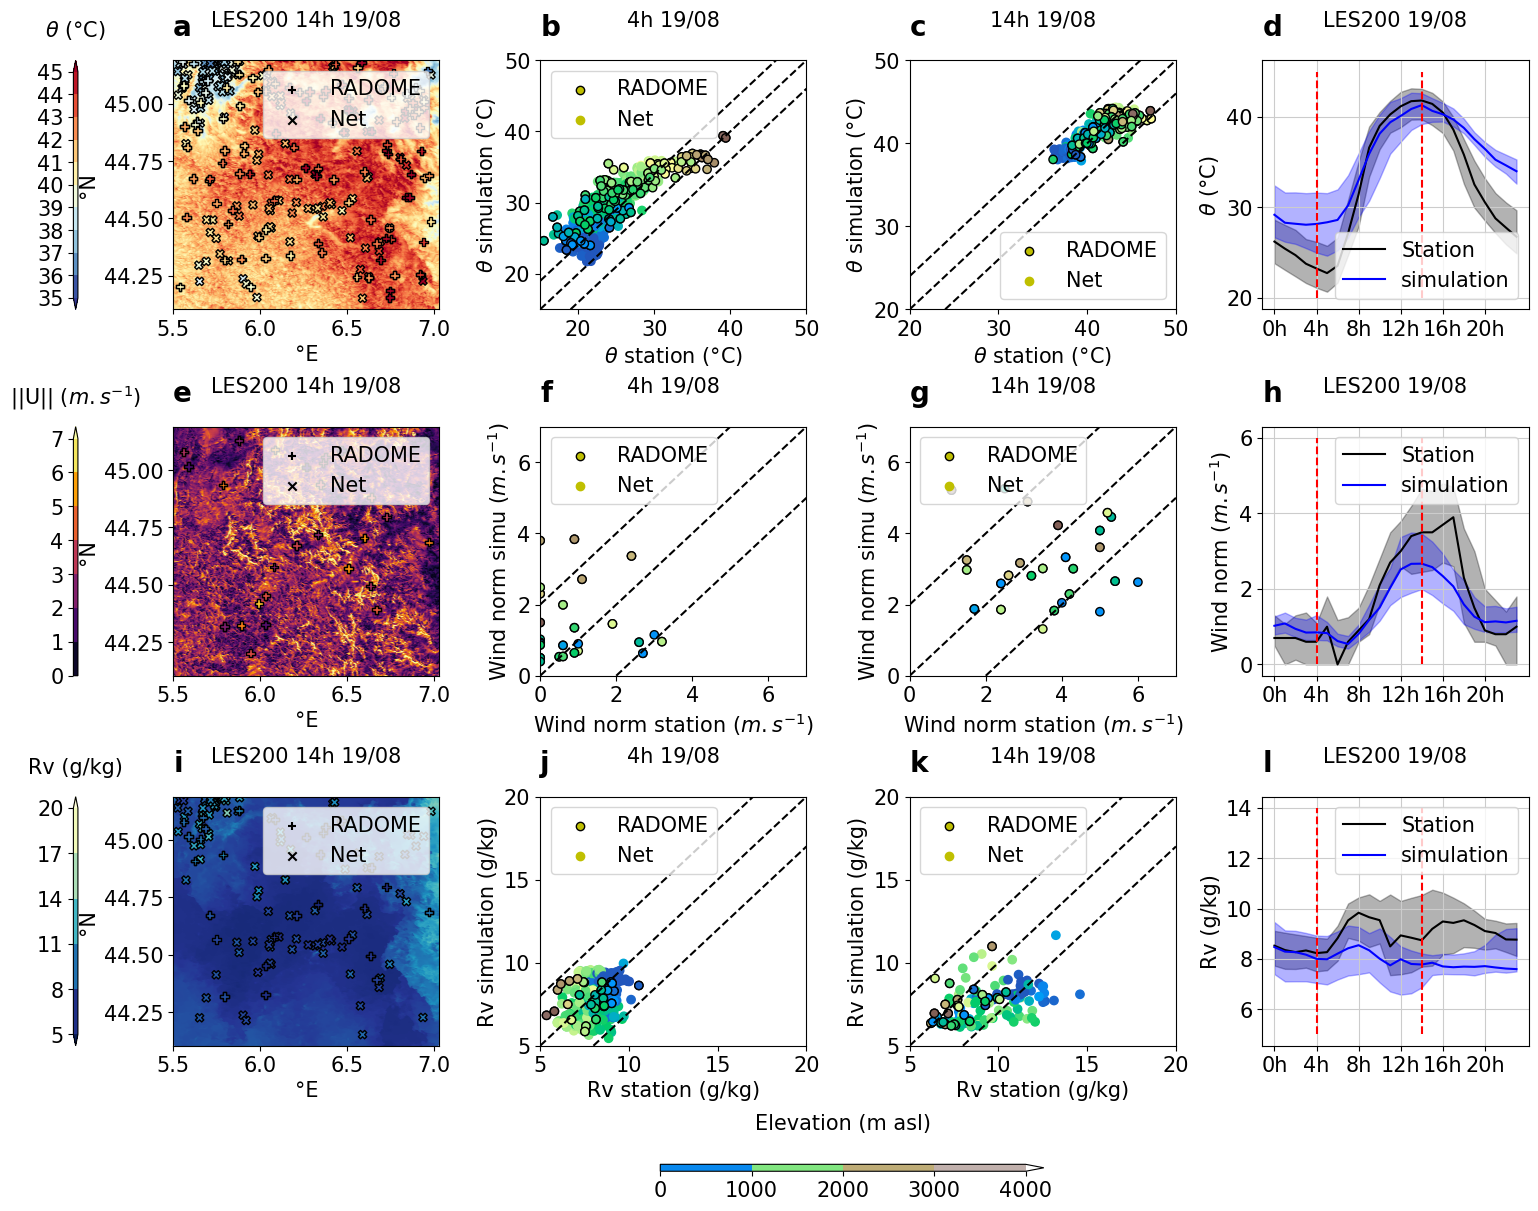

In [12]:
var = ['T_simu','T_sta','U_moy_simu','U_moy_sta','Rv_simu','Rv_sta','P_simu','P_sta']

lows,medians,highs = plotting_time_series_quantils_rvuv(Comp_simu_rvuv_19_son,vars)

day = 19
size = 15
type = 'LES200'
plotting(reduced_son_19_14,reduced_comp_net_19_son_14,reduced_comp_mf_19_son_14,reduced_comp_net_19_son_4,reduced_comp_mf_19_son_4,Comp_simu_rvuv_19_son,day,type,'RvUV_19_son','b')

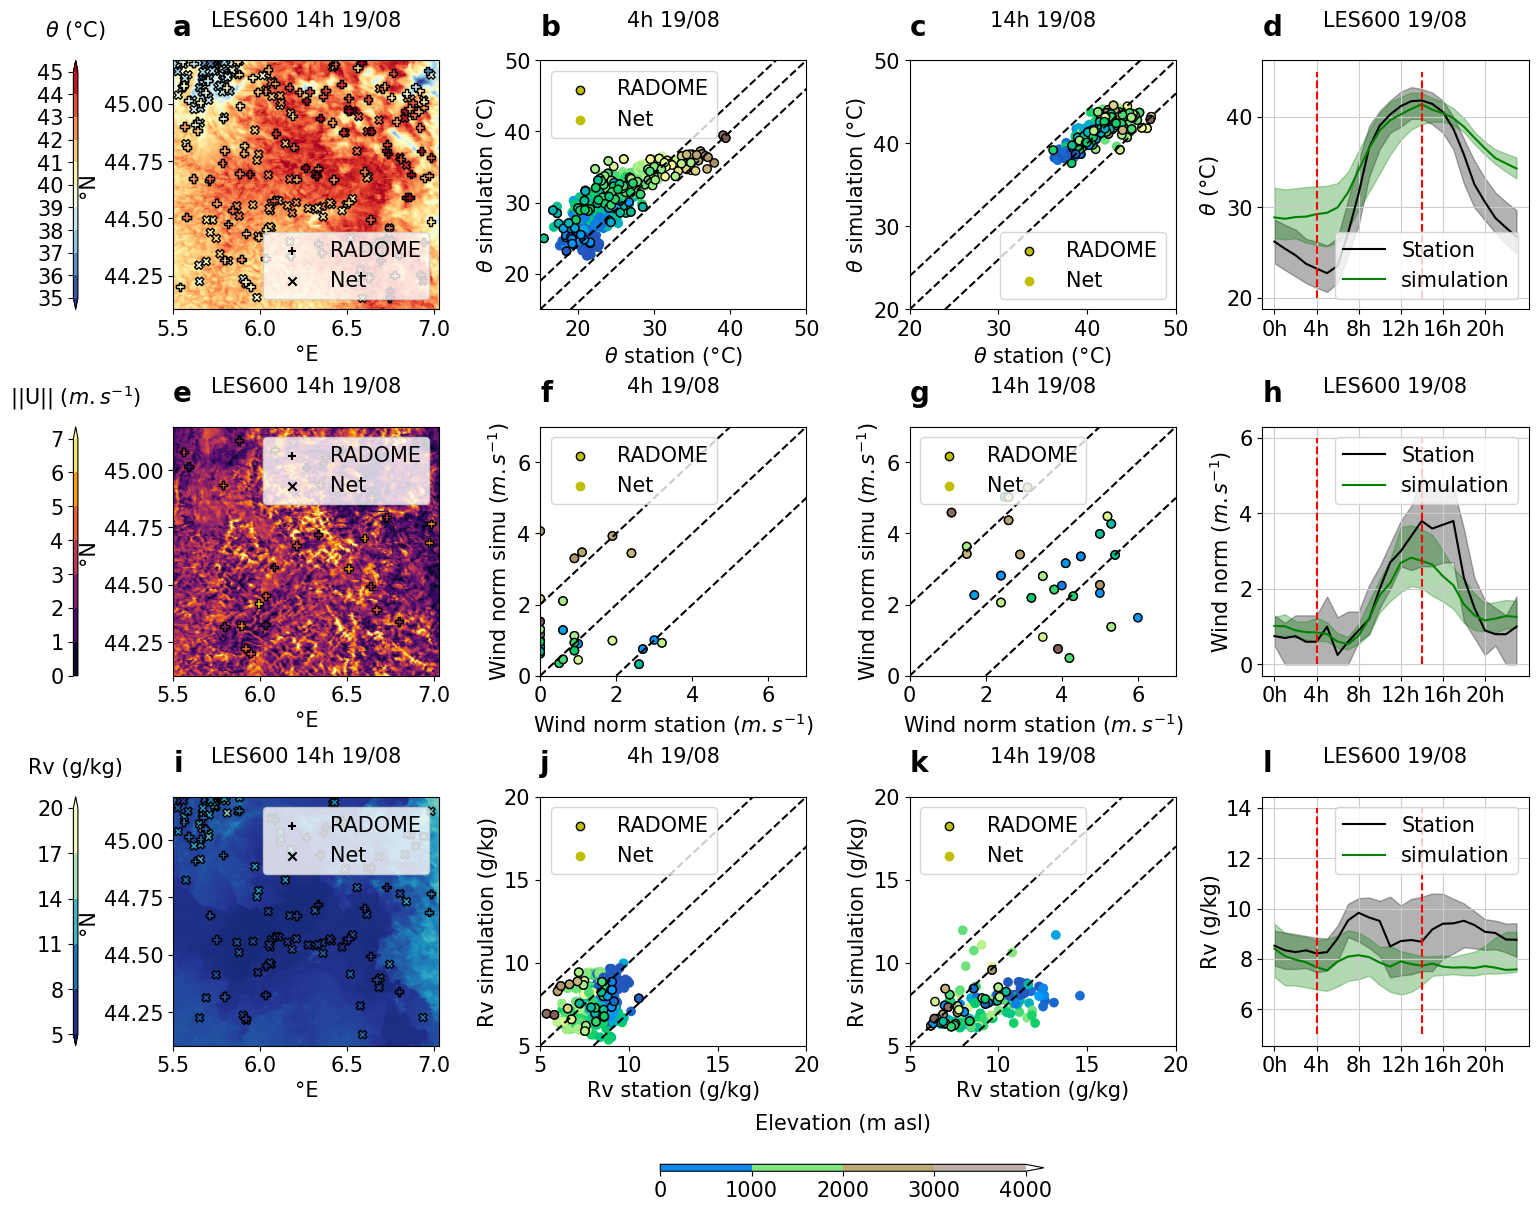

In [14]:
var = ['T_simu','T_sta','U_moy_simu','U_moy_sta','Rv_simu','Rv_sta','P_simu','P_sta']

lows,medians,highs = plotting_time_series_quantils_rvuv(Comp_simu_rvuv_19_father,vars)

day = 19
size = 15
type = 'LES600'
plotting(reduced_father_19_14,reduced_comp_net_19_father_14,reduced_comp_mf_19_father_14,reduced_comp_net_19_father_4,reduced_comp_mf_19_father_4,Comp_simu_rvuv_19_father,day,type,'RvUV_19_father','g')

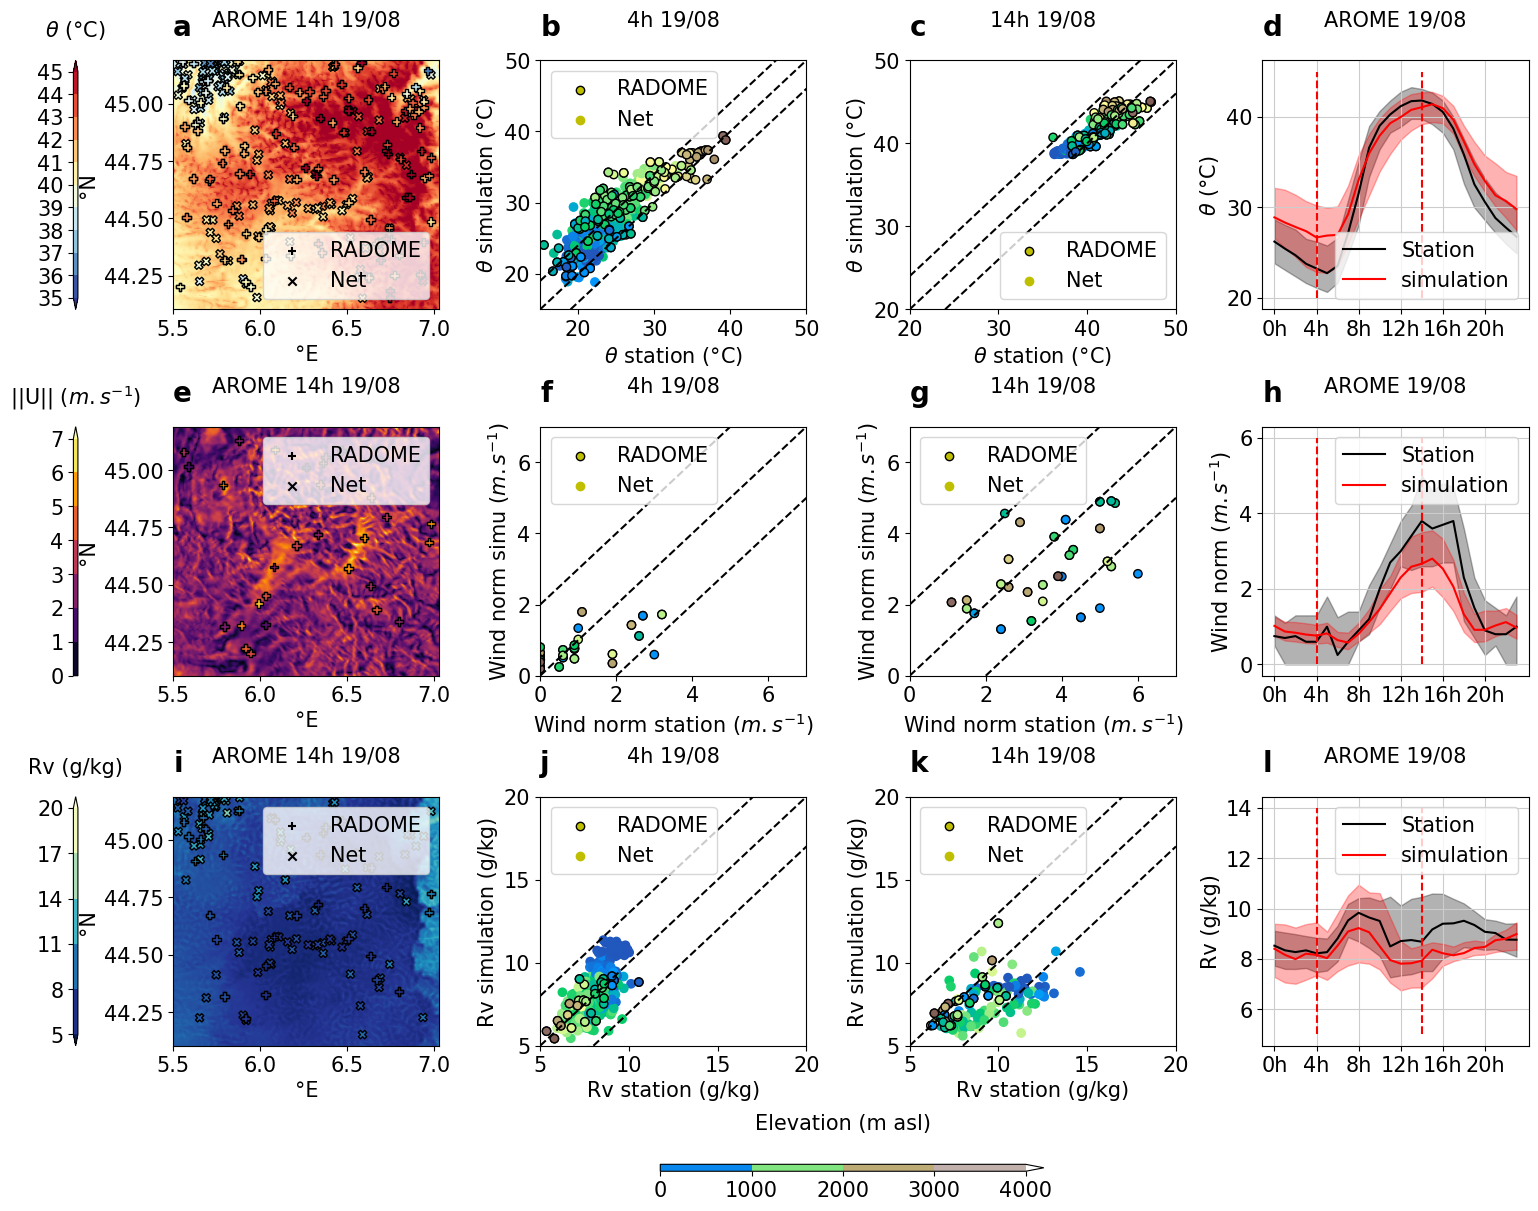

In [15]:
var = ['T_simu','T_sta','U_moy_simu','U_moy_sta','Rv_simu','Rv_sta','P_simu','P_sta']

lows,medians,highs = plotting_time_series_quantils_rvuv(Comp_simu_rvuv_19_AROME,vars)

day = 19
size = 15
type = 'AROME'
plotting(reduced_AROME_19_14,reduced_comp_net_19_AROME_14,reduced_comp_mf_19_AROME_14,reduced_comp_net_19_AROME_4,reduced_comp_mf_19_AROME_4,Comp_simu_rvuv_19_AROME,day,type,'RvUV_19_AROME','r')